# Problema 2 

Modifica el ejemplo del fuego forestal, de tal manera que sea posible iniciar el fuego en cualquier parte del entorno. A su vez:
- considera al menos tres diferentes tipos de árboles, los cuales se incendian con mayor o menor facilidad. 
- Genere al menos 5 simulaciones, y 
- presente los resultados en el PDF en el que se va a entregar con esta actividad.

In [31]:
# Model design
import agentpy as ap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

In [32]:
class ForestModel(ap.Model):

    def setup(self):

        # Create agents (trees)
        n_trees1 = int(self.p['Tree density'] * (self.p.size**2) / 3)
        trees1 = self.agents1 = ap.AgentList(self, n_trees1)
       # trees2 = trees1
        #trees3 = trees1
        
        n_trees2 = int(self.p['Tree density'] * (self.p.size**2) / 3)
        trees2 = self.agents2 = ap.AgentList(self, n_trees2)

        n_trees3 = int(self.p['Tree density'] * (self.p.size**2) / 3)
        trees3 = self.agents3 = ap.AgentList(self, n_trees3)
        
        

        # Create grid (forest)
        self.forest = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.forest.add_agents(trees1, random=True, empty=True)
        self.forest.add_agents(trees2, random=True, empty=True)
        self.forest.add_agents(trees3, random=True, empty=True)

        # Initiate a dynamic variable for all trees
        # Condition 0: Alive, 1: Burning, 2: Burned
        trees1.condition = 0
        trees2.condition = 0
        trees3.condition = 0
        

        # Start a fire from the left side of the grid
        unfortunate_trees = [
            self.forest.agents[self.random.randint(0, self.p.size-1), self.random.randint(0, self.p.size-1)],
            self.forest.agents[self.random.randint(0, self.p.size-1), self.random.randint(0, self.p.size-1)],
            self.forest.agents[self.random.randint(0, self.p.size-1), self.random.randint(0, self.p.size-1)]
        ]

        for unfortunate_tree in unfortunate_trees:
            while len(unfortunate_tree.condition) == 0:
                unfortunate_tree = self.forest.agents[self.random.randint(0, self.p.size-1), self.random.randint(0, self.p.size-1)]
                
            unfortunate_tree.condition = 1

    def step(self):

        # Select burning trees
        burning_trees1 = self.agents1.select(self.agents1.condition == 1)
        burning_trees2 = self.agents2.select(self.agents2.condition == 1)
        burning_trees3 = self.agents3.select(self.agents3.condition == 1)

        # Spread fire
        for tree1 in burning_trees1:
            for neighbor in self.forest.neighbors(tree1):
                if neighbor.condition == 0:
                    neighbor.condition = 1 # Neighbor starts burning
            tree1.condition = 2 # Tree burns out
        
        for tree2 in burning_trees2:
            for neighbor in self.forest.neighbors(tree2):
                if neighbor.condition == 0:
                    if self.random.randint(0,10) < 7:
                        neighbor.condition = 1 # Neighbor starts burning
            tree2.condition = 2 # Tree burns out
            
        for tree3 in burning_trees3:
            for neighbor in self.forest.neighbors(tree3):
                if neighbor.condition == 0:
                    if self.random.randint(0,10) < 4:
                        neighbor.condition = 1 # Neighbor starts burning
            tree3.condition = 2 # Tree burns out

        # Stop simulation if no fire is left
        if len(burning_trees1) == 0 and len(burning_trees2) == 0 and len(burning_trees3) == 0:
            self.stop()

    def end(self):

        # Document a measure at the end of the simulation
        burned_trees = len(self.agents1.select(self.agents1.condition == 2)) + len(self.agents2.select(self.agents2.condition == 2)) + len(self.agents3.select(self.agents3.condition == 2))
        self.report('Percentage of burned trees',
                    burned_trees / (len(self.agents3) + len(self.agents2) + len(self.agents3)))

In [33]:
# Define parameters

parameters = {
    'Tree density': 0.6, # Percentage of grid covered by trees
    'size': 20, # Height and length of the grid
    'steps': 100,
}

In [34]:
# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.forest.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#d62c2c', 2:'#e5e5e5', None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a forest fire\n"
                 f"Time-step: {model.t}, Trees left: "
                 f"{len(model.agents1.select(model.agents1.condition == 0)) + len(model.agents2.select(model.agents2.condition == 0)) + len(model.agents3.select(model.agents3.condition == 0))}")

fig, ax = plt.subplots()
model = ForestModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=15))

In [35]:
# Prepare parameter sample
parameters = {
    'Tree density': ap.Range(0.2, 0.6), 
    'size': 100
}
sample = ap.Sample(parameters, n=30)

In [39]:
# Perform experiment
exp = ap.Experiment(ForestModel, sample, iterations=10)
results = exp.run()

Scheduled runs: 300
Completed: 300, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:01:52.471652


In [40]:
# Save and load data
results.save()
results = ap.DataDict.load('ForestModel')

Data saved to ap_output/ForestModel_7
Loading from directory ap_output/ForestModel_7/
Loading info.json - Successful
Loading parameters_constants.json - Successful
Loading parameters_log.json - Successful
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful


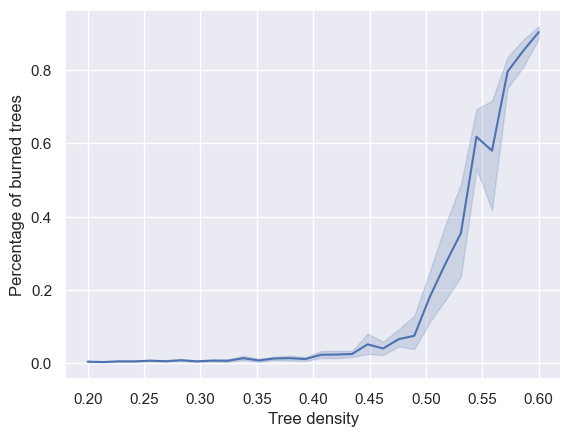

In [41]:
# Plot sensitivity
sns.set_theme()
sns.lineplot(
    data=results.arrange_reporters(), 
    x='Tree density', 
    y='Percentage of burned trees'
);